In [1]:
from unityagents import UnityEnvironment
env_file = 'Tennis_Linux/Tennis.x86_64'#"Tennis_Windows_x86_64\Tennis.exe"
env = UnityEnvironment(file_name=env_file, no_graphics = True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
import torch
import numpy as np
from collections import deque
import progressbar as pb
import matplotlib.pyplot as plt
from utils import OUprocess, Reply_buffer
from Tennis_agent import SelfPlay_Agent

using device:  cpu
NO grad. clipping used.


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('states shape: ',states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
states shape:  (2, 24)
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


In [4]:
T_max = 1000
max_buffer = 16000 # int(1.e+6) too large, for 1000 episodes the lengs was 38051
buffer = Reply_buffer(max_buffer)
noise_decay = 1#0.999
noise_lvl = 0.2
ouA = OUprocess(action_size, sigma=noise_lvl)
ouB = OUprocess(action_size, sigma=noise_lvl)
batch_size = 128 #512 is bad; 64 is better (w. lr 2e-4)
update_steps = 1 #with 5 it learns but slow and gets 'stuck' in 0.1-0.2; with 30 (and GD_steps=5) is worse
GD_steps = 2 #with 20 it learns but slow and gets 'stuck' in 0.1-0.2, with 5 (and update_steps=30 & 2) is worse
lra=5.e-4
lrc=5.e-4
agent = SelfPlay_Agent(state_size, action_size, num_agents, lr_act=lra, lr_crit=lrc)

nr_episodes = 600

In [5]:

widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar()]#, ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=nr_episodes).start()
min_buffer = num_agents*batch_size
assert min_buffer<max_buffer, 'minimal length of buffer for update (min_buffer) smaller than buffer memory (max_buffer)!'
ACloss = []
l_exists = False
e_score = np.zeros(nr_episodes)
rolling_avg = np.zeros(nr_episodes)
rolling_window = deque(maxlen=100)
t=0
for i in range(nr_episodes):                                         # play game for nr_episodes episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:#t<T_max:
        t+=1
#         if t==T_max:
#             assert False, "t reached T_max!"
            
        # select action
        actA  = agent.act(states[0]).data.cpu().numpy() + ouA.noise()
        actB = agent.act(states[1]).data.cpu().numpy() + ouB.noise()
        actions = np.clip([actA, actB],-1,1) # select an action (for each agent)
        # execute and observe
        #actions = [np.array([0.1,1]),np.array([0.1,1])]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        # store in replay buffer
        samples = [states, np.asarray(actions), np.asarray(rewards), next_states, dones]
        buffer.store(samples)
        # roll over states to next time step
        states = next_states                               
        # keep track of scores
        scores += env_info.rewards                         # update the score (for each agent)
        # Update agents
        if ((t-1) % update_steps == 0) and len(buffer.buffer) > batch_size:
#             print('Updating networks at time ',t-1)
            l_exists = True
            #for a_i in np.random.permutation(num_agents): #ideally you would like to sample the agents randomly 
            for ep in range(GD_steps):
                minibatch = buffer.get_batch(batch_size)  # get batch of size (batch_size x 5) where the 2nd dim corresponds to (s,a,r,s',done)
                agent_i = np.random.choice(num_agents,len(minibatch))
                closs = agent.update_critic(minibatch,agent_i)
                aloss = agent.update_actor(minibatch,agent_i)
            #ACloss.append([aloss,closs])
                    
        # Update target network
        agent.target_update()
        # exit loop if episode finished
        if np.any(dones): 
            break
    
    if l_exists:
        ACloss.append([aloss,closs])
    ouA.reset()
    ouB.reset()
    ouA.sigma *= noise_decay
    ouB.sigma *= noise_decay
    
    e_score[i] = np.max(scores)
    rolling_window.append(e_score[i])
    rolling_avg[i] = np.mean(np.array(rolling_window))
    if (i+1) % 20 == 0:
        print('Total score (averaged over agents) episode {}: {}'.format(i+1,np.mean(scores)))
        print('Score (max over agents) from episode {}: {}'.format(i+1, e_score[i]))
        print('Rolling average score: {}'.format(rolling_avg[i]))
        print('Noise level: ',ouA.sigma,ouB.sigma)
        if l_exists:
            print("Actor loss: {} | Critic loss: {}".format(*ACloss[-1]))
    
    # update progress widget bar
    timer.update(i+1)
    
timer.finish()

Total score (averaged over agents) episode 20: -0.004999999888241291
Score (max over agents) from episode 20: 0.0
Rolling average score: 0.009500000160187483
Noise level:  0.2 0.2
Actor loss: 0.05077890306711197 | Critic loss: 5.670694008585997e-05


Total score (averaged over agents) episode 40: -0.004999999888241291
Score (max over agents) from episode 40: 0.0
Rolling average score: 0.007250000117346644
Noise level:  0.2 0.2
Actor loss: 0.02959064021706581 | Critic loss: 1.1631144843704533e-05


Total score (averaged over agents) episode 60: -0.004999999888241291
Score (max over agents) from episode 60: 0.0
Rolling average score: 0.006500000103066365
Noise level:  0.2 0.2
Actor loss: 0.015494457446038723 | Critic loss: 2.240915819129441e-05


Total score (averaged over agents) episode 80: -0.004999999888241291
Score (max over agents) from episode 80: 0.0
Rolling average score: 0.019375000311993063
Noise level:  0.2 0.2
Actor loss: 0.000493804516736418 | Critic loss: 1.1254195669607725e-05


Total score (averaged over agents) episode 100: -0.004999999888241291
Score (max over agents) from episode 100: 0.0
Rolling average score: 0.017400000281631946
Noise level:  0.2 0.2
Actor loss: -0.008163287304341793 | Critic loss: 7.82106799306348e-05


Total score (averaged over agents) episode 120: -0.004999999888241291
Score (max over agents) from episode 120: 0.0
Rolling average score: 0.01550000024959445
Noise level:  0.2 0.2
Actor loss: -0.016192717477679253 | Critic loss: 9.087694343179464e-05


Total score (averaged over agents) episode 140: -0.004999999888241291
Score (max over agents) from episode 140: 0.0
Rolling average score: 0.014500000234693288
Noise level:  0.2 0.2
Actor loss: -0.021870464086532593 | Critic loss: 2.757500078587327e-05


Total score (averaged over agents) episode 160: -0.004999999888241291
Score (max over agents) from episode 160: 0.0
Rolling average score: 0.018500000294297932
Noise level:  0.2 0.2
Actor loss: -0.03879354149103165 | Critic loss: 7.006446685409173e-05


Total score (averaged over agents) episode 180: -0.004999999888241291
Score (max over agents) from episode 180: 0.0
Rolling average score: 0.011800000183284283
Noise level:  0.2 0.2
Actor loss: -0.052549488842487335 | Critic loss: 7.853342685848475e-05


Total score (averaged over agents) episode 200: 0.04500000085681677
Score (max over agents) from episode 200: 0.10000000149011612
Rolling average score: 0.02820000045001507
Noise level:  0.2 0.2
Actor loss: -0.09066401422023773 | Critic loss: 0.00013156392378732562


Total score (averaged over agents) episode 220: 0.04500000085681677
Score (max over agents) from episode 220: 0.10000000149011612
Rolling average score: 0.04700000075623393
Noise level:  0.2 0.2
Actor loss: -0.08993229269981384 | Critic loss: 9.017416596179828e-05


Total score (averaged over agents) episode 240: 0.04500000085681677
Score (max over agents) from episode 240: 0.10000000149011612
Rolling average score: 0.067600001078099
Noise level:  0.2 0.2
Actor loss: -0.10212474316358566 | Critic loss: 0.00011720559268724173


Total score (averaged over agents) episode 260: 0.04500000085681677
Score (max over agents) from episode 260: 0.10000000149011612
Rolling average score: 0.08510000135749579
Noise level:  0.2 0.2
Actor loss: -0.11502042412757874 | Critic loss: 0.00010725724860094488


Total score (averaged over agents) episode 280: 0.04500000085681677
Score (max over agents) from episode 280: 0.10000000149011612
Rolling average score: 0.10470000166445971
Noise level:  0.2 0.2
Actor loss: -0.12470328062772751 | Critic loss: 0.0001699265412753448


Total score (averaged over agents) episode 300: 0.09500000160187483
Score (max over agents) from episode 300: 0.10000000149011612
Rolling average score: 0.10770000170916319
Noise level:  0.2 0.2
Actor loss: -0.14099504053592682 | Critic loss: 0.0002682642953004688


Total score (averaged over agents) episode 320: 0.04500000085681677
Score (max over agents) from episode 320: 0.10000000149011612
Rolling average score: 0.11060000173747539
Noise level:  0.2 0.2
Actor loss: -0.15296632051467896 | Critic loss: 0.0002685180807020515


Total score (averaged over agents) episode 340: 0.04500000085681677
Score (max over agents) from episode 340: 0.10000000149011612
Rolling average score: 0.1108000017516315
Noise level:  0.2 0.2
Actor loss: -0.1648431122303009 | Critic loss: 0.0003362905408721417


Total score (averaged over agents) episode 360: 0.04500000085681677
Score (max over agents) from episode 360: 0.10000000149011612
Rolling average score: 0.11720000183209776
Noise level:  0.2 0.2
Actor loss: -0.17782475054264069 | Critic loss: 0.0003967301163356751


Total score (averaged over agents) episode 380: 0.09500000160187483
Score (max over agents) from episode 380: 0.10000000149011612
Rolling average score: 0.10960000170394778
Noise level:  0.2 0.2
Actor loss: -0.1926882416009903 | Critic loss: 0.00029292836552485824


Total score (averaged over agents) episode 400: 0.09500000160187483
Score (max over agents) from episode 400: 0.10000000149011612
Rolling average score: 0.10180000158026814
Noise level:  0.2 0.2
Actor loss: -0.187448188662529 | Critic loss: 0.00047611549962311983


Total score (averaged over agents) episode 420: 0.1450000023469329
Score (max over agents) from episode 420: 0.20000000298023224
Rolling average score: 0.10870000168681145
Noise level:  0.2 0.2
Actor loss: -0.19291388988494873 | Critic loss: 0.000365753861842677


Total score (averaged over agents) episode 440: -0.004999999888241291
Score (max over agents) from episode 440: 0.0
Rolling average score: 0.11380000174045563
Noise level:  0.2 0.2
Actor loss: -0.20315714180469513 | Critic loss: 0.00036195508437231183


Total score (averaged over agents) episode 460: 0.6950000105425715
Score (max over agents) from episode 460: 0.7000000104308128
Rolling average score: 0.12760000199079513
Noise level:  0.2 0.2
Actor loss: -0.22585837543010712 | Critic loss: 0.0002953481744043529


Total score (averaged over agents) episode 480: 0.5450000083073974
Score (max over agents) from episode 480: 0.6000000089406967
Rolling average score: 0.156500002425164
Noise level:  0.2 0.2
Actor loss: -0.2364051640033722 | Critic loss: 0.00039467078750021756


Total score (averaged over agents) episode 500: 0.5950000090524554
Score (max over agents) from episode 500: 0.6000000089406967
Rolling average score: 0.18180000279098749
Noise level:  0.2 0.2
Actor loss: -0.25878196954727173 | Critic loss: 0.0004137508221901953


Total score (averaged over agents) episode 520: 0.1450000023469329
Score (max over agents) from episode 520: 0.20000000298023224
Rolling average score: 0.2121000032313168
Noise level:  0.2 0.2
Actor loss: -0.2589825689792633 | Critic loss: 0.0004883221117779613


Total score (averaged over agents) episode 540: 0.3450000053271651
Score (max over agents) from episode 540: 0.4000000059604645
Rolling average score: 0.2438000037148595
Noise level:  0.2 0.2
Actor loss: -0.27395743131637573 | Critic loss: 0.0004295783000998199


Total score (averaged over agents) episode 560: 0.09500000160187483
Score (max over agents) from episode 560: 0.10000000149011612
Rolling average score: 0.2420000036433339
Noise level:  0.2 0.2
Actor loss: -0.28952255845069885 | Critic loss: 0.0004711207584477961


Total score (averaged over agents) episode 580: 0.6450000097975135
Score (max over agents) from episode 580: 0.7000000104308128
Rolling average score: 0.23420000351965428
Noise level:  0.2 0.2
Actor loss: -0.30312737822532654 | Critic loss: 0.000275064492598176


Total score (averaged over agents) episode 600: 0.19500000309199095
Score (max over agents) from episode 600: 0.20000000298023224
Rolling average score: 0.24830000372603536
Noise level:  0.2 0.2
Actor loss: -0.3224090039730072 | Critic loss: 0.0004121695819776505


In [6]:
print([torch.mean(trgt-net) for trgt, net in zip(agent.actor_target.parameters(),agent.actor.parameters())])

[tensor(0.0002, grad_fn=<MeanBackward0>), tensor(-4.5344e-05, grad_fn=<MeanBackward0>), tensor(2.6235e-05, grad_fn=<MeanBackward0>), tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0005, grad_fn=<MeanBackward0>), tensor(0.0010, grad_fn=<MeanBackward0>), tensor(0.0001, grad_fn=<MeanBackward0>), tensor(0.0021, grad_fn=<MeanBackward0>)]


(594, 2)


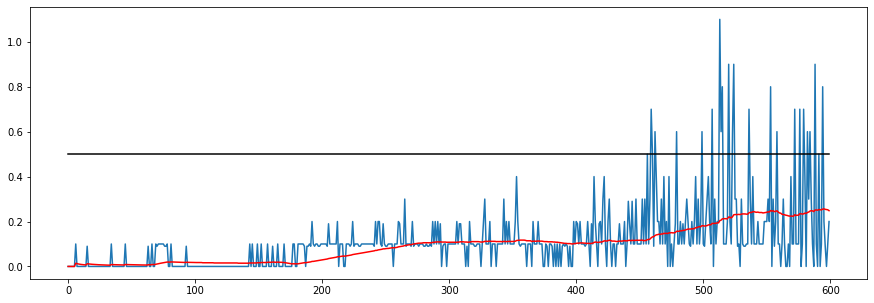

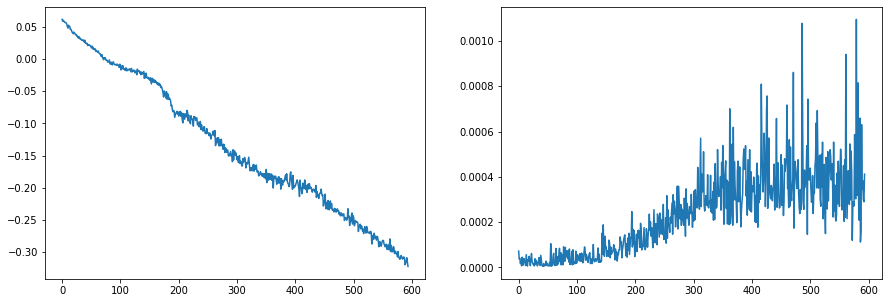

In [18]:
ACloss = np.asarray(ACloss)
print(ACloss.shape)
plt.figure(figsize=(15,5))
plt.plot(e_score)
plt.plot(rolling_avg,'r')
plt.plot(0.5*np.ones_like(rolling_avg),'k')
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(ACloss[:,0])
plt.subplot(122)
plt.plot(ACloss[:,1])


In [8]:
# env.close()
print('lra {}, lrc {}, noise_lvl {}, noise_decay {}, batch_size {}, update_steps {}, GD_steps {}'.format(lra, lrc, noise_lvl,noise_decay,batch_size,
                                                                                         update_steps,GD_steps))

lra 0.0005, lrc 0.0005, noise_lvl 0.2, noise_decay 1, batch_size 128, update_steps 1, GD_steps 2


In [9]:
len(buffer.buffer)

16000

In [16]:
print(t)

30028


In [10]:
for param_grp in agent.actor_optim.param_groups:
    print(param_grp['lr'])
for param_grp in agent.critic_optim.param_groups:
    print(param_grp['lr'])

0.0005
0.0005


In [11]:
rolling_avg.max()

0.2564000038430095